Grid search code to optimise clustering_analysis.py hyperparameters

In [1]:
import itertools
import os
import datetime
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from umap import UMAP
import hdbscan
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

# Load data
with open("../data/chunks.json") as f:
    data = json.load(f)

texts = [entry["text"] for entry in data]

In [2]:
# --------------------------------------------------
# Remove stopwords ("and", "the", "is", "that" etc)
# and add custom stopwrods to the list
# Remove standalone numbers
# --------------------------------------------------

# Expand list of stopwords to remove industry-specific noise
# and months of the year
iata_stopwords = [
    "sky", "flight", "air", "aviation", "iata", "sector", "industry",
    "annual", "review", "general", "director", "transport", "association",
    "chief", "executive", "officer", "bisignani", "giovanni", "ceo"
]
months = [
    "january", "february", "march", "april", "may", "june",
    "july", "august", "september", "october", "november", "december"
]
month_abbr = [
    "jan", "feb", "mar", "apr", "may", "jun",
    "jul", "aug", "sep", "oct", "nov", "dec"
]
custom_stopwords = sorted(list(ENGLISH_STOP_WORDS.union(iata_stopwords, months, month_abbr)))

# Only allow tokens with at least one alphabet character (i.e. excludes numbers)
token_pattern = r"(?u)\b[a-zA-Z]*[a-zA-Z][a-zA-Z]*\b"

custom_vectorizer = CountVectorizer(
    stop_words=custom_stopwords, # Remove stopwords
    ngram_range=(1, 2),          # Include unigrams and bigrams
    token_pattern=token_pattern
)

In [3]:
# Lightweight sentence transformer from Hugging Face
# https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2
# Turns sentences into dense vectors 
# https://medium.com/@yasindusanjeewa8/dense-vectors-in-natural-language-processing-06818dff5cd7

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

In [4]:
# ------------------------------------------------------------
# Define Grid Search Parameters
# ------------------------------------------------------------
n_neighbors_grid = [5, 10, 15]
min_cluster_size_grid = [10, 15, 20, 25, 30]
model_dir = "../models/hp_optimisation/"
os.makedirs(model_dir, exist_ok=True)
random_state = 42

In [ ]:
# ------------------------------------------------------------
# Grid Search Loop
# ------------------------------------------------------------
results = []

for n_neighbors, min_cluster_size in itertools.product(n_neighbors_grid, min_cluster_size_grid):
    print(f"Training model with n_neighbors={n_neighbors}, min_cluster_size={min_cluster_size}")

    umap_model = UMAP(
        n_neighbors=n_neighbors,
        n_components=5,
        min_dist=0.0,
        metric="cosine",
        random_state=random_state
    )

    hdbscan_model = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=5,
        metric="euclidean",
        cluster_selection_method="eom",
        prediction_data=True
    )

    topic_model = BERTopic(
        embedding_model=embedding_model,
        vectorizer_model=custom_vectorizer,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        calculate_probabilities=True,
        verbose=True
    )

    topics, probs = topic_model.fit_transform(texts)
    n_topics = len(set(t for t in topics if t != -1))

    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    model_name = f"bertopic_neighbors{n_neighbors}_cluster{min_cluster_size}_{timestamp}"
    topic_model.save(os.path.join(model_dir, model_name))

    results.append({
        "model_name": model_name,
        "n_neighbors": n_neighbors,
        "min_cluster_size": min_cluster_size,
        "n_topics": n_topics
    })

    print(f"Saved {model_name} with {n_topics} topics.")

2025-04-25 17:44:45,085 - BERTopic - Embedding - Transforming documents to embeddings.


Training model with n_neighbors=5, min_cluster_size=10


Batches:   0%|          | 0/97 [00:00<?, ?it/s]

2025-04-25 17:44:55,351 - BERTopic - Embedding - Completed ✓
2025-04-25 17:44:55,352 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-25 17:45:04,101 - BERTopic - Dimensionality - Completed ✓
2025-04-25 17:45:04,102 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-25 17:45:04,598 - BERTopic - Cluster - Completed ✓
2025-04-25 17:45:04,601 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-25 17:45:05,012 - BERTopic - Representation - Completed ✓
2025-04-25 17:45:05,352 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
2025-04-25 17:45:05,896 - BERTopic - Embedding - Transforming documents to embeddings.


Saved bertopic_neighbors5_cluster10_20250425_174505 with 115 topics.
Training model with n_neighbors=5, min_cluster_size=15


Batches:   0%|          | 0/97 [00:00<?, ?it/s]

2025-04-25 17:45:12,647 - BERTopic - Embedding - Completed ✓
2025-04-25 17:45:12,647 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-25 17:45:19,109 - BERTopic - Dimensionality - Completed ✓
2025-04-25 17:45:19,110 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-25 17:45:19,386 - BERTopic - Cluster - Completed ✓
2025-04-25 17:45:19,388 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-25 17:45:19,798 - BERTopic - Representation - Completed ✓
2025-04-25 17:45:20,090 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
2025-04-25 17:45:20,588 - BERTopic - Embedding - Transforming documents to embeddings.


Saved bertopic_neighbors5_cluster15_20250425_174520 with 72 topics.
Training model with n_neighbors=5, min_cluster_size=20


Batches:   0%|          | 0/97 [00:00<?, ?it/s]

2025-04-25 17:45:27,378 - BERTopic - Embedding - Completed ✓
2025-04-25 17:45:27,379 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-25 17:45:33,843 - BERTopic - Dimensionality - Completed ✓
2025-04-25 17:45:33,843 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-25 17:45:34,041 - BERTopic - Cluster - Completed ✓
2025-04-25 17:45:34,043 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-25 17:45:34,440 - BERTopic - Representation - Completed ✓
2025-04-25 17:45:34,707 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
2025-04-25 17:45:35,201 - BERTopic - Embedding - Transforming documents to embeddings.


Saved bertopic_neighbors5_cluster20_20250425_174534 with 48 topics.
Training model with n_neighbors=5, min_cluster_size=25


Batches:   0%|          | 0/97 [00:00<?, ?it/s]

2025-04-25 17:45:41,920 - BERTopic - Embedding - Completed ✓
2025-04-25 17:45:41,921 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-25 17:45:48,387 - BERTopic - Dimensionality - Completed ✓
2025-04-25 17:45:48,387 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-25 17:45:48,549 - BERTopic - Cluster - Completed ✓
2025-04-25 17:45:48,551 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-25 17:45:48,941 - BERTopic - Representation - Completed ✓
2025-04-25 17:45:49,196 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
2025-04-25 17:45:49,670 - BERTopic - Embedding - Transforming documents to embeddings.


Saved bertopic_neighbors5_cluster25_20250425_174549 with 36 topics.
Training model with n_neighbors=5, min_cluster_size=30


Batches:   0%|          | 0/97 [00:00<?, ?it/s]

2025-04-25 17:45:56,470 - BERTopic - Embedding - Completed ✓
2025-04-25 17:45:56,471 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-25 17:46:02,923 - BERTopic - Dimensionality - Completed ✓
2025-04-25 17:46:02,924 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-25 17:46:03,070 - BERTopic - Cluster - Completed ✓
2025-04-25 17:46:03,072 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-25 17:46:03,462 - BERTopic - Representation - Completed ✓
2025-04-25 17:46:03,698 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
2025-04-25 17:46:04,205 - BERTopic - Embedding - Transforming documents to embeddings.


Saved bertopic_neighbors5_cluster30_20250425_174603 with 29 topics.
Training model with n_neighbors=10, min_cluster_size=10


Batches:   0%|          | 0/97 [00:00<?, ?it/s]

2025-04-25 17:46:11,100 - BERTopic - Embedding - Completed ✓
2025-04-25 17:46:11,100 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-25 17:46:18,403 - BERTopic - Dimensionality - Completed ✓
2025-04-25 17:46:18,404 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-25 17:46:18,872 - BERTopic - Cluster - Completed ✓
2025-04-25 17:46:18,874 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-25 17:46:19,312 - BERTopic - Representation - Completed ✓
2025-04-25 17:46:19,651 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
2025-04-25 17:46:20,142 - BERTopic - Embedding - Transforming documents to embeddings.


Saved bertopic_neighbors10_cluster10_20250425_174619 with 105 topics.
Training model with n_neighbors=10, min_cluster_size=15


Batches:   0%|          | 0/97 [00:00<?, ?it/s]

2025-04-25 17:46:27,106 - BERTopic - Embedding - Completed ✓
2025-04-25 17:46:27,106 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-25 17:46:34,414 - BERTopic - Dimensionality - Completed ✓
2025-04-25 17:46:34,415 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-25 17:46:34,678 - BERTopic - Cluster - Completed ✓
2025-04-25 17:46:34,680 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-25 17:46:35,089 - BERTopic - Representation - Completed ✓
2025-04-25 17:46:35,382 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
2025-04-25 17:46:35,887 - BERTopic - Embedding - Transforming documents to embeddings.


Saved bertopic_neighbors10_cluster15_20250425_174635 with 62 topics.
Training model with n_neighbors=10, min_cluster_size=20


Batches:   0%|          | 0/97 [00:00<?, ?it/s]

2025-04-25 17:46:42,687 - BERTopic - Embedding - Completed ✓
2025-04-25 17:46:42,687 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-25 17:46:49,983 - BERTopic - Dimensionality - Completed ✓
2025-04-25 17:46:49,984 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-25 17:46:50,171 - BERTopic - Cluster - Completed ✓
2025-04-25 17:46:50,173 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-25 17:46:50,574 - BERTopic - Representation - Completed ✓
2025-04-25 17:46:50,826 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
2025-04-25 17:46:51,309 - BERTopic - Embedding - Transforming documents to embeddings.


Saved bertopic_neighbors10_cluster20_20250425_174650 with 41 topics.
Training model with n_neighbors=10, min_cluster_size=25


Batches:   0%|          | 0/97 [00:00<?, ?it/s]

2025-04-25 17:46:58,121 - BERTopic - Embedding - Completed ✓
2025-04-25 17:46:58,122 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-25 17:47:05,412 - BERTopic - Dimensionality - Completed ✓
2025-04-25 17:47:05,413 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-25 17:47:05,559 - BERTopic - Cluster - Completed ✓
2025-04-25 17:47:05,560 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-25 17:47:05,951 - BERTopic - Representation - Completed ✓
2025-04-25 17:47:06,186 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
2025-04-25 17:47:06,665 - BERTopic - Embedding - Transforming documents to embeddings.


Saved bertopic_neighbors10_cluster25_20250425_174706 with 29 topics.
Training model with n_neighbors=10, min_cluster_size=30


Batches:   0%|          | 0/97 [00:00<?, ?it/s]

2025-04-25 17:47:13,457 - BERTopic - Embedding - Completed ✓
2025-04-25 17:47:13,458 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-25 17:47:20,763 - BERTopic - Dimensionality - Completed ✓
2025-04-25 17:47:20,764 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-25 17:47:20,900 - BERTopic - Cluster - Completed ✓
2025-04-25 17:47:20,902 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-25 17:47:21,296 - BERTopic - Representation - Completed ✓
2025-04-25 17:47:21,528 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
2025-04-25 17:47:22,079 - BERTopic - Embedding - Transforming documents to embeddings.


Saved bertopic_neighbors10_cluster30_20250425_174721 with 26 topics.
Training model with n_neighbors=15, min_cluster_size=10


Batches:   0%|          | 0/97 [00:00<?, ?it/s]

2025-04-25 17:47:28,878 - BERTopic - Embedding - Completed ✓
2025-04-25 17:47:28,878 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-25 17:47:36,619 - BERTopic - Dimensionality - Completed ✓
2025-04-25 17:47:36,620 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-25 17:47:37,064 - BERTopic - Cluster - Completed ✓
2025-04-25 17:47:37,066 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-25 17:47:37,491 - BERTopic - Representation - Completed ✓
2025-04-25 17:47:37,831 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
2025-04-25 17:47:38,340 - BERTopic - Embedding - Transforming documents to embeddings.


Saved bertopic_neighbors15_cluster10_20250425_174737 with 102 topics.
Training model with n_neighbors=15, min_cluster_size=15


Batches:   0%|          | 0/97 [00:00<?, ?it/s]

2025-04-25 17:47:45,186 - BERTopic - Embedding - Completed ✓
2025-04-25 17:47:45,187 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-25 17:47:53,025 - BERTopic - Dimensionality - Completed ✓
2025-04-25 17:47:53,025 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-25 17:47:53,274 - BERTopic - Cluster - Completed ✓
2025-04-25 17:47:53,276 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-25 17:47:53,682 - BERTopic - Representation - Completed ✓
2025-04-25 17:47:53,973 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
2025-04-25 17:47:54,441 - BERTopic - Embedding - Transforming documents to embeddings.


Saved bertopic_neighbors15_cluster15_20250425_174753 with 63 topics.
Training model with n_neighbors=15, min_cluster_size=20


Batches:   0%|          | 0/97 [00:00<?, ?it/s]

2025-04-25 17:48:01,268 - BERTopic - Embedding - Completed ✓
2025-04-25 17:48:01,269 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-25 17:48:09,144 - BERTopic - Dimensionality - Completed ✓
2025-04-25 17:48:09,145 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-25 17:48:09,345 - BERTopic - Cluster - Completed ✓
2025-04-25 17:48:09,347 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-25 17:48:09,765 - BERTopic - Representation - Completed ✓
2025-04-25 17:48:10,036 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
2025-04-25 17:48:10,533 - BERTopic - Embedding - Transforming documents to embeddings.


Saved bertopic_neighbors15_cluster20_20250425_174810 with 50 topics.
Training model with n_neighbors=15, min_cluster_size=25


Batches:   0%|          | 0/97 [00:00<?, ?it/s]

2025-04-25 17:48:17,387 - BERTopic - Embedding - Completed ✓
2025-04-25 17:48:17,387 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-25 17:48:25,186 - BERTopic - Dimensionality - Completed ✓
2025-04-25 17:48:25,187 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-25 17:48:25,329 - BERTopic - Cluster - Completed ✓
2025-04-25 17:48:25,331 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-25 17:48:25,726 - BERTopic - Representation - Completed ✓
2025-04-25 17:48:25,962 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
2025-04-25 17:48:26,435 - BERTopic - Embedding - Transforming documents to embeddings.


Saved bertopic_neighbors15_cluster25_20250425_174825 with 29 topics.
Training model with n_neighbors=15, min_cluster_size=30


Batches:   0%|          | 0/97 [00:00<?, ?it/s]

2025-04-25 17:48:33,263 - BERTopic - Embedding - Completed ✓
2025-04-25 17:48:33,264 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-25 17:48:41,082 - BERTopic - Dimensionality - Completed ✓
2025-04-25 17:48:41,082 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-25 17:48:41,214 - BERTopic - Cluster - Completed ✓
2025-04-25 17:48:41,216 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-25 17:48:41,608 - BERTopic - Representation - Completed ✓
2025-04-25 17:48:41,848 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


Saved bertopic_neighbors15_cluster30_20250425_174841 with 26 topics.


In [10]:
# ------------------------------------------------------------
# Display Grid Search Results
# ------------------------------------------------------------
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("n_topics", ascending=False)
results_df.reset_index(drop=True, inplace=True)

results_df

,model_name,n_neighbors,min_cluster_size,n_topics
0,bertopic_neighbors5_cluster10_20250425_174505,5,10,115
1,bertopic_neighbors10_cluster10_20250425_174619,10,10,105
2,bertopic_neighbors15_cluster10_20250425_174737,15,10,102
3,bertopic_neighbors5_cluster15_20250425_174520,5,15,72
4,bertopic_neighbors15_cluster15_20250425_174753,15,15,63
5,bertopic_neighbors10_cluster15_20250425_174635,10,15,62
6,bertopic_neighbors15_cluster20_20250425_174810,15,20,50
7,bertopic_neighbors5_cluster20_20250425_174534,5,20,48
8,bertopic_neighbors10_cluster20_20250425_174650,10,20,41
9,bertopic_neighbors5_cluster25_20250425_174549,5,25,36


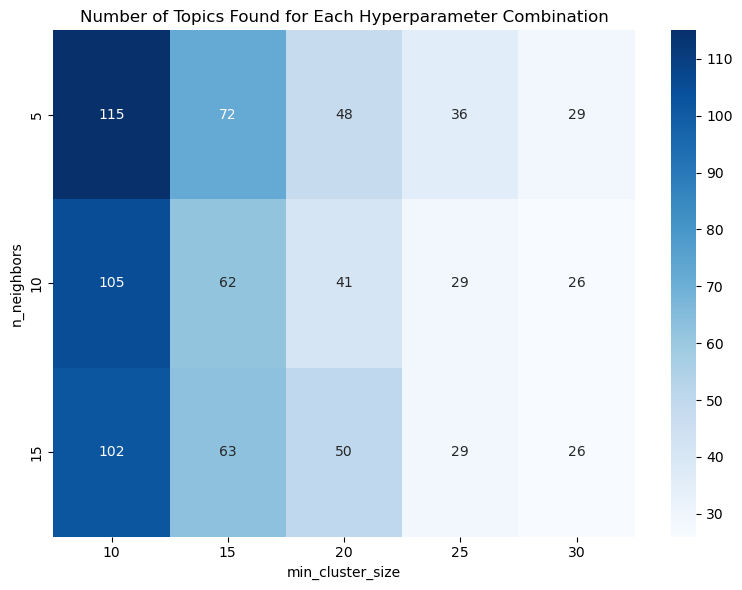

In [11]:
# ------------------------------------------------------------
# Plot Results as Heatmap
# ------------------------------------------------------------
pivot_table = results_df.pivot(index="n_neighbors", columns="min_cluster_size", values="n_topics")
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt="d", cmap="Blues")
plt.title("Number of Topics Found for Each Hyperparameter Combination")
plt.xlabel("min_cluster_size")
plt.ylabel("n_neighbors")
plt.tight_layout()
plt.show()



In [ ]:
# ------------------------------------------------
# More fine-tuned scan around promising min_cluster_size
# values and exploring min_dists settings
# ------------------------------------------------
from itertools import product

# Parameters to scan
min_cluster_sizes = [25, 28, 30]
umap_min_dists = [0.0, 0.1, 0.2]
n_neighbors = 10

# Create an empty list to collect results
results = []

# Loop through combinations
for min_cluster_size, umap_min_dist in product(min_cluster_sizes, umap_min_dists):
    print(f"Training model with min_cluster_size={min_cluster_size}, umap_min_dist={umap_min_dist}")
    
    # Define UMAP and HDBSCAN models
    umap_model = UMAP(
        n_neighbors=n_neighbors,
        n_components=5,
        min_dist=umap_min_dist,
        metric="cosine",
        random_state=42
    )

    hdbscan_model = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=5,
        metric="euclidean",
        cluster_selection_method='eom',
        prediction_data=True
    )

    # Train BERTopic
    topic_model = BERTopic(
        embedding_model=embedding_model,
        vectorizer_model=custom_vectorizer,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        calculate_probabilities=True,
        verbose=True
    )
    
    topics, probs = topic_model.fit_transform(texts)
    n_topics = len(set(t for t in topics if t != -1))

    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    model_name = f"../models/hp_optimisation/bertopic_neighbors{n_neighbors}_cluster{min_cluster_size}_{timestamp}"
    topic_model.save(os.path.join(model_dir, model_name))
    
    # Record results
    results.append({
        "min_cluster_size": min_cluster_size,
        "umap_min_dist": umap_min_dist,
        "n_neighbors": n_neighbors,
        "n_topics": n_topics
    })

    print(f"Saved {model_name} with {n_topics} topics.")


2025-04-25 17:58:43,199 - BERTopic - Embedding - Transforming documents to embeddings.


Training model with min_cluster_size=25, umap_min_dist=0.0


Batches:   0%|          | 0/97 [00:00<?, ?it/s]

2025-04-25 17:58:50,573 - BERTopic - Embedding - Completed ✓
2025-04-25 17:58:50,573 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-25 17:58:57,567 - BERTopic - Dimensionality - Completed ✓
2025-04-25 17:58:57,568 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-25 17:58:57,710 - BERTopic - Cluster - Completed ✓
2025-04-25 17:58:57,713 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-25 17:58:58,141 - BERTopic - Representation - Completed ✓
2025-04-25 17:58:58,380 - BERTopic - Embedding - Transforming documents to embeddings.


Model found 29 topics
Training model with min_cluster_size=25, umap_min_dist=0.1


Batches:   0%|          | 0/97 [00:00<?, ?it/s]

2025-04-25 17:59:05,630 - BERTopic - Embedding - Completed ✓
2025-04-25 17:59:05,630 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-25 17:59:12,763 - BERTopic - Dimensionality - Completed ✓
2025-04-25 17:59:12,764 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-25 17:59:12,912 - BERTopic - Cluster - Completed ✓
2025-04-25 17:59:12,914 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-25 17:59:13,312 - BERTopic - Representation - Completed ✓
2025-04-25 17:59:13,549 - BERTopic - Embedding - Transforming documents to embeddings.


Model found 30 topics
Training model with min_cluster_size=25, umap_min_dist=0.2


Batches:   0%|          | 0/97 [00:00<?, ?it/s]

2025-04-25 17:59:20,427 - BERTopic - Embedding - Completed ✓
2025-04-25 17:59:20,427 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-25 17:59:27,578 - BERTopic - Dimensionality - Completed ✓
2025-04-25 17:59:27,580 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-25 17:59:27,728 - BERTopic - Cluster - Completed ✓
2025-04-25 17:59:27,730 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-25 17:59:28,185 - BERTopic - Representation - Completed ✓
2025-04-25 17:59:28,423 - BERTopic - Embedding - Transforming documents to embeddings.


Model found 28 topics
Training model with min_cluster_size=28, umap_min_dist=0.0


Batches:   0%|          | 0/97 [00:00<?, ?it/s]

2025-04-25 17:59:35,335 - BERTopic - Embedding - Completed ✓
2025-04-25 17:59:35,336 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-25 17:59:42,546 - BERTopic - Dimensionality - Completed ✓
2025-04-25 17:59:42,547 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-25 17:59:42,687 - BERTopic - Cluster - Completed ✓
2025-04-25 17:59:42,689 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-25 17:59:43,131 - BERTopic - Representation - Completed ✓
2025-04-25 17:59:43,365 - BERTopic - Embedding - Transforming documents to embeddings.


Model found 28 topics
Training model with min_cluster_size=28, umap_min_dist=0.1


Batches:   0%|          | 0/97 [00:00<?, ?it/s]

2025-04-25 17:59:50,319 - BERTopic - Embedding - Completed ✓
2025-04-25 17:59:50,320 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-25 17:59:57,529 - BERTopic - Dimensionality - Completed ✓
2025-04-25 17:59:57,529 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-25 17:59:57,666 - BERTopic - Cluster - Completed ✓
2025-04-25 17:59:57,668 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-25 17:59:58,065 - BERTopic - Representation - Completed ✓
2025-04-25 17:59:58,294 - BERTopic - Embedding - Transforming documents to embeddings.


Model found 26 topics
Training model with min_cluster_size=28, umap_min_dist=0.2


Batches:   0%|          | 0/97 [00:00<?, ?it/s]

2025-04-25 18:00:05,126 - BERTopic - Embedding - Completed ✓
2025-04-25 18:00:05,127 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-25 18:00:12,351 - BERTopic - Dimensionality - Completed ✓
2025-04-25 18:00:12,352 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-25 18:00:12,500 - BERTopic - Cluster - Completed ✓
2025-04-25 18:00:12,502 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-25 18:00:12,903 - BERTopic - Representation - Completed ✓
2025-04-25 18:00:13,141 - BERTopic - Embedding - Transforming documents to embeddings.


Model found 28 topics
Training model with min_cluster_size=30, umap_min_dist=0.0


Batches:   0%|          | 0/97 [00:00<?, ?it/s]

2025-04-25 18:00:19,875 - BERTopic - Embedding - Completed ✓
2025-04-25 18:00:19,875 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-25 18:00:27,153 - BERTopic - Dimensionality - Completed ✓
2025-04-25 18:00:27,154 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-25 18:00:27,290 - BERTopic - Cluster - Completed ✓
2025-04-25 18:00:27,292 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-25 18:00:27,694 - BERTopic - Representation - Completed ✓
2025-04-25 18:00:27,933 - BERTopic - Embedding - Transforming documents to embeddings.


Model found 26 topics
Training model with min_cluster_size=30, umap_min_dist=0.1


Batches:   0%|          | 0/97 [00:00<?, ?it/s]

2025-04-25 18:00:34,797 - BERTopic - Embedding - Completed ✓
2025-04-25 18:00:34,797 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-25 18:00:42,108 - BERTopic - Dimensionality - Completed ✓
2025-04-25 18:00:42,109 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-25 18:00:42,243 - BERTopic - Cluster - Completed ✓
2025-04-25 18:00:42,245 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-25 18:00:42,692 - BERTopic - Representation - Completed ✓
2025-04-25 18:00:42,923 - BERTopic - Embedding - Transforming documents to embeddings.


Model found 24 topics
Training model with min_cluster_size=30, umap_min_dist=0.2


Batches:   0%|          | 0/97 [00:00<?, ?it/s]

2025-04-25 18:00:49,815 - BERTopic - Embedding - Completed ✓
2025-04-25 18:00:49,815 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-25 18:00:57,142 - BERTopic - Dimensionality - Completed ✓
2025-04-25 18:00:57,143 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-25 18:00:57,285 - BERTopic - Cluster - Completed ✓
2025-04-25 18:00:57,287 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-25 18:00:57,688 - BERTopic - Representation - Completed ✓


Model found 27 topics


In [13]:
# After all models are trained, create a DataFrame
results_df = pd.DataFrame(results)

# Sort results for easier reading
results_df = results_df.sort_values(by=["min_cluster_size", "umap_min_dist"]).reset_index(drop=True)

# Show the table
results_df

,min_cluster_size,umap_min_dist,n_neighbors,n_topics
0,25,0.0,10,29
1,25,0.1,10,30
2,25,0.2,10,28
3,28,0.0,10,28
4,28,0.1,10,26
5,28,0.2,10,28
6,30,0.0,10,26
7,30,0.1,10,24
8,30,0.2,10,27


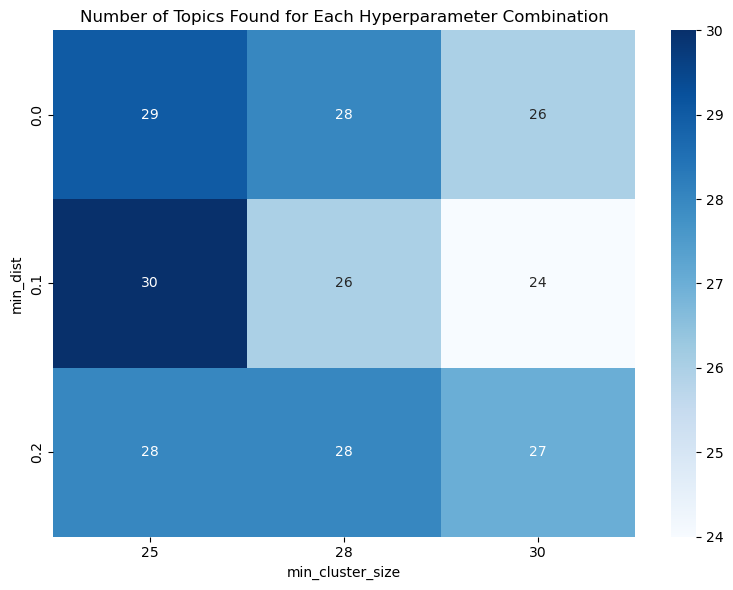

In [14]:
# ------------------------------------------------------------
# Plot Results as Heatmap
# ------------------------------------------------------------
pivot_table = results_df.pivot(index="umap_min_dist", columns="min_cluster_size", values="n_topics")
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt="d", cmap="Blues")
plt.title("Number of Topics Found for Each Hyperparameter Combination")
plt.xlabel("min_cluster_size")
plt.ylabel("min_dist")
plt.tight_layout()
plt.show()